_This notebook was written and developed by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/ClassiPyGRB)._

# Swift/BAT Data Interpolation
The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

In previous notebooks, we preprocess the 64 ms data from Swift/BAT using **ClassiPyGRB**, but data is assumed to be equally spaced. Unfortunately, the high signal-to-noise ratio data ($res=10000$) does not have a uniform separation in its points, therefore, it is not possible to implement the pre-processing step (e.g., it isn't possible to standardize the time basis for all GRBs simultaneously).

To solve this problem, the fastest method is to interpolate between data points in each light curve. This notebook summarizes this process in an intuitive way. Through this document, we are using the _python3_ implementations from the _ClassiPyGRB_ package. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we need to import the _SWIFT_ instance of **ClassiPyGRB** to our notebook (and some other packages needed in this notebook):

In [1]:
from ClassiPyGRB import SWIFT
# Packages needed in this notebook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Changing the Swift GRB binning
There are some cases in which we need to use different data resolutions and binning; handling these situations can be solved in this package by managing the _resolution_ $res$ argument.

Through **ClassiPyGRB**, you can change the _resolution_ variable to $2$, $8$, $16$, $64$, and $256$ ms respectively. Additionally, you can set $res=1000$ for 1s binning and $res=10000$ to use data with a signal-to-noise ratio higher than 5 or 10 s binning (10s data don't have uniform time spacing).

In **ClassiPyGRB** you have a high-level of saving data customization. You can set the following paths:
- $root\_path$ (str): Main path to save data/results from SWIFT. Unique mandatory path to ensure the functionality of SWIFT Class.
- $data\_path$ (str, optional): Path to save data from SWIFT. Defaults to Data folder inside root\_path.
- $original\_data\_path$ (str, optional): Path to save non-manipulated data from SWIFT. Defaults to Original\_Data folder inside data\_path.
- $noise\_data\_path$ (str, optional): Path to save noise-reduced data from SWIFT. Defaults to Noise\_Filtered\_Data folder inside data\_path.
- $results\_path$ (str, optional): Path to save non-manipulated data from SWIFT. Defaults to Results folder inside root\_path.

Moreover, in **ClassiPyGRB** you can customize the bands used from Swift/BAT data using the parameter `n_bands`. This parameter consists of an array of integers ranging from 1 to 5, where each integer represents a unique band from Swift. In order, 1 represents the 15-25 keV band, 2 represents the 25-50 keV band, 3 represents the 50-100 keV band, 4 represents the 100-350 keV band, and 5 represents the 15-350 keV band. Therefore, for example, by using $n\_bands=[2, 4]$ **ClassiPyGRB** understands that you would like to work with 25-50 keV and 100-350 keV bands. Setting `n_bands` appropriately can help you to improve time of preprocess, results of t-SNE and custom plotting from Swift/BAT.

However, the most simple and easy implementation of **ClassiPyGRB** only uses $root\_path$ as a main folder and saves both data and results in this path:


In [2]:
swift = SWIFT(root_path=r'type-your-path-here', res=10000, n_bands=[1, 2, 3, 4, 5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


Last, extract the GRB Names of Swift, and remove the GRBs with download errors, only if you already have downloaded data form Swift/BAT:

In [3]:
df = swift.summary_table()
GRB_names = df['GRBname'] # GRB Names total array
try:
    df = pd.read_table(os.path.join(swift.original_data_path, f"Errors_{swift.end}.txt"), sep='\t', comment='#', names=['GRB Name', 'Error'], header=None)
    GRB_errors = df['GRB Name']
except FileNotFoundError:
    pass
else:
    GRB_names = np.unique(GRB_names[~GRB_names.isin(GRB_errors)])
print(f'There are {len(GRB_names)} GRBs in the current working Swift/BAT dataset.')

There are 1498 GRBs in the current working Swift/BAT dataset.


**Note:** If you have notr downloaded the data yet, check the _BAT_Data_Download_ notebook. It is strongly recommended to download data before to run this notebook, although the instances used here can work without any previous downloaded data, the time of execution can be highly affected for this.

# Interpolation - Basic Usage

As a first example, lets interpolate a usual Pandas Dataframe containing some popular functions in a fixed time interval:

In [4]:
times = np.linspace(0, 2*np.pi, 10)  # Defining times
cols = np.array([times, np.sin(times), np.cos(times), np.power(times, 3/2), np.square(times), np.sqrt(times)])

df = pd.DataFrame({
    "times": cols[0],
    "sin": cols[1],
    "cos": cols[2],
    "times^3": cols[3],
    "times^2": cols[4],
    "sqrt(times)": cols[5]
})
print(df)

      times           sin       cos    times^3    times^2  sqrt(times)
0  0.000000  0.000000e+00  1.000000   0.000000   0.000000     0.000000
1  0.698132  6.427876e-01  0.766044   0.583319   0.487388     0.835543
2  1.396263  9.848078e-01  0.173648   1.649875   1.949551     1.181636
3  2.094395  8.660254e-01 -0.500000   3.031014   4.386491     1.447203
4  2.792527  3.420201e-01 -0.939693   4.666551   7.798206     1.671086
5  3.490659 -3.420201e-01 -0.939693   6.521703  12.184697     1.868330
6  4.188790 -8.660254e-01 -0.500000   8.573002  17.545963     2.046653
7  4.886922 -9.848078e-01  0.173648  10.803217  23.882006     2.210638
8  5.585054 -6.427876e-01  0.766044  13.199000  31.192824     2.363272
9  6.283185 -2.449294e-16  1.000000  15.749610  39.478418     2.506628


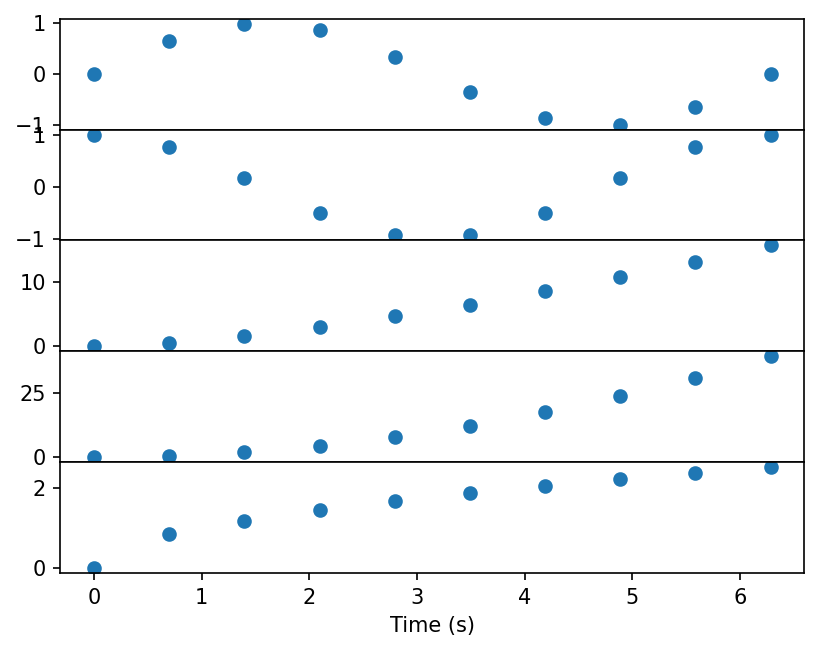

In [5]:
%matplotlib inline
fig5 = plt.figure(dpi=150)
gs = fig5.add_gridspec(nrows=5, hspace=0)
ax = gs.subplots(sharex=True)
ax[-1].set_xlabel("Time (s)")
for i in range(0, len(df.columns)-1, 1):
    ax[i].scatter(df.iloc[:, 0], df.iloc[:, i+1])

As it has been illustrated, there are 10 data points in each column, and the time interval is $[0, 2\pi]$. Now, lets interpolate this data frame to a new time interval with 100 data points. To do this job, you can use the `grb_interpolate` function from **ClassiPyGRB**. It takes as arguments:

1. The data frame or array to interpolate (where the first column corresponds to the original time set).
2. The new time interval or a fixed resolution intervals to interpolate.
3. The kind of interpolation (related with the order of the polynomial to interpolate).
4. The number of data points to pack in each bin.

The last argument is optional, and it is used only when interpolation is not linear. In non-linear cases, the process followed is: First, it takes each GRB band and separates them into n arrays of length _pack_num_ (default=10). Then it interpolates each array using a polynomial of degree n (depending on kind value). The value of _pack_num_ plays a significant role when you use high order polynomial. Lower _pack_num_ improves the result but takes higher execution time.

## Linear Interpolation

Let's interpolate the data frame using a linear interpolation and a fixed resolution of 64 milliseconds:

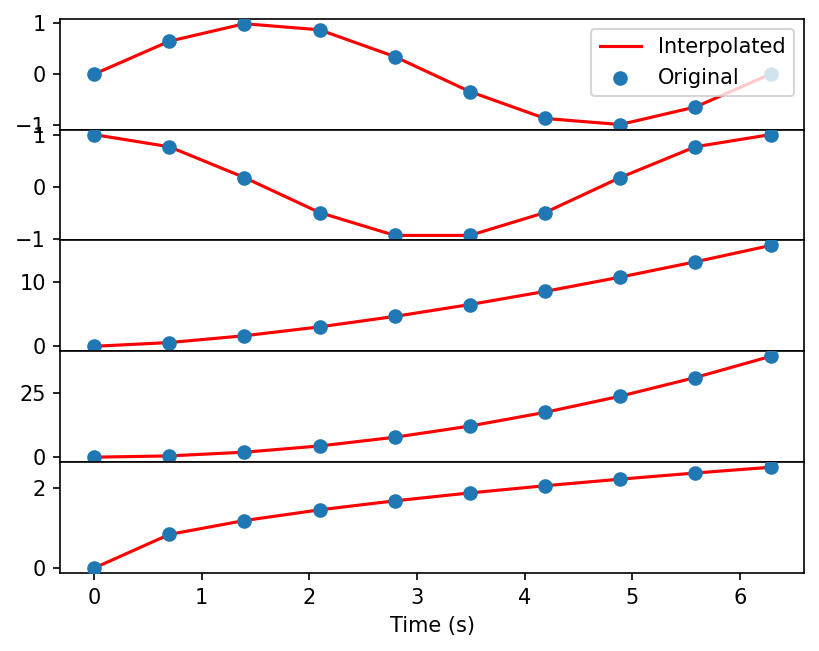

In [6]:
inter_data = swift.grb_interpolate(data=df, res=64, kind='linear')
fig5 = plt.figure(dpi=150)
gs = fig5.add_gridspec(nrows=5, hspace=0)
ax = gs.subplots(sharex=True)
for i in range(0, len(df.columns)-1, 1):
    ax[i].plot(inter_data.iloc[:, 0], inter_data.iloc[:, i+1], c='r', label='Interpolated')
    ax[i].scatter(df.iloc[:, 0], df.iloc[:, i+1], label='Original', zorder=5)
ax[-1].set_xlabel("Time (s)")
ax[0].legend()

## Non-Linear Interpolation

Now, lets interpolate the data frame using a cubic interpolation and a new_time interval defined, with a pack length of 5:

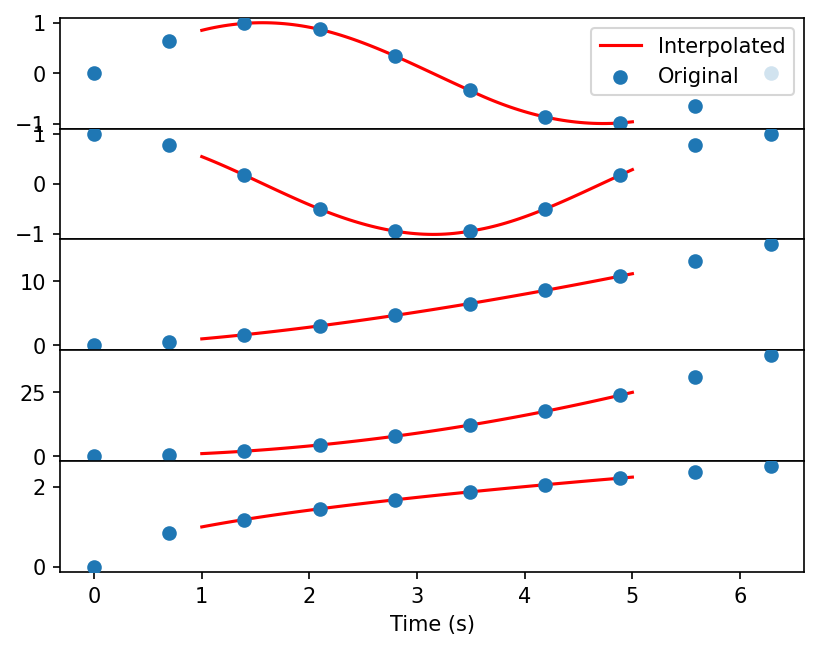

In [7]:
new_times = np.linspace(1, 5, 100)
inter_data = swift.grb_interpolate(data=df, new_time=new_times, kind='cubic', pack_num=5)
fig5 = plt.figure(dpi=150)
gs = fig5.add_gridspec(nrows=5, hspace=0)
ax = gs.subplots(sharex=True)
for i in range(0, len(df.columns)-1, 1):
    ax[i].plot(inter_data.iloc[:, 0], inter_data.iloc[:, i+1], c='r', label='Interpolated')
    ax[i].scatter(df.iloc[:, 0], df.iloc[:, i+1], label='Original', zorder=5)
ax[-1].set_xlabel("Time (s)")
ax[0].legend()

From the previous figure, it is clear that **ClassiPyGRB** interpolates data in a high level of customization. But, these functions are easily interpolated using Pandas Dataframe methods. Therefore, why use **ClassiPyGRB**? The answer is simple: **ClassiPyGRB** is designed to work with large data sets, and it is optimized to work with them.

## Interpolation - Swift/BAT Data

In Swift/BAT data, the classification is done by setting a standard time basis. Unfortunately, the time basis is not the same for all GRBs in high signal-to-noise ratio data (or 10s binning). So, the interpolation is donde to standardize the time basis for all GRBs.

First, consider the example GRB with a high signal-to-noise ratio (check the [Basic Usage](https://github.com/KenethGarcia/ClassiPyGRB/blob/d96dd57f98bb48229ec2cb2ee3d96632eaa4dfbe/docs/1.Basic_Usage.ipynb) notebook) limited out of $T_{100}$.

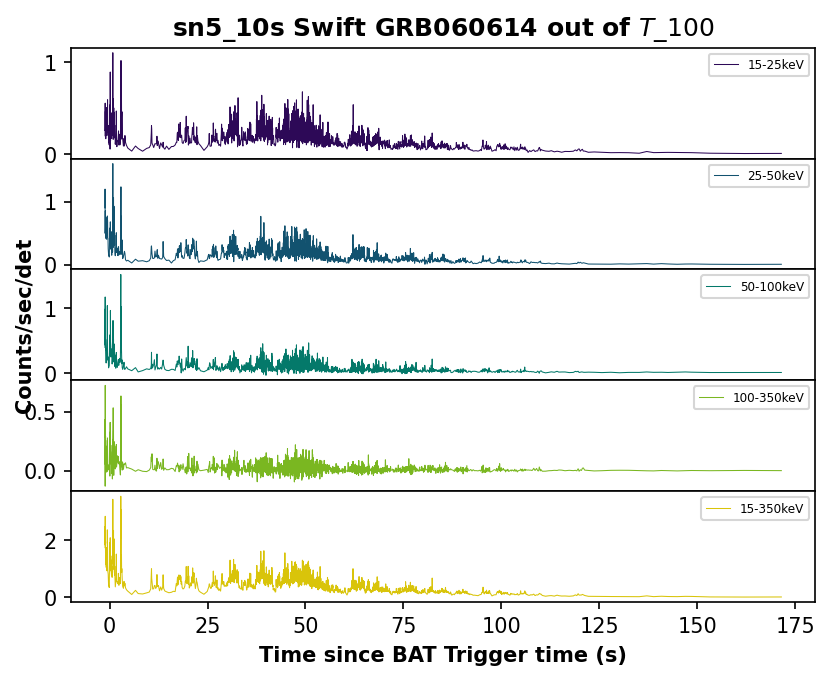

In [8]:
name = 'GRB060614'  # Change this name if you want another GRB
ax = swift.plot_any_grb(name, t=100)
del df, inter_data, new_times, times, cols, fig5, gs

To interpolate this light curve, we need to take each band and fit a polynomial function. The `grb_interpolate` instance takes an argument called 'kind' to select the polynomial order, namely:

* 'linear' to use 1-order polynomial
* 'quadratic' to use 2-order polynomial
* 'cubic' to use 3-order polynomial

There are more types of 'kind' arguments. Please check more info and details at [this link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html).

## Linear Interpolation

Let's see what happens when we use interpolate with kind='linear' between $T_{100}$ and using a fixed resolution of 64 milliseconds.

1. Import the data for the example GRB:

In [9]:
example = swift.lc_limiter(name, t=100)
print(example)

        Time(s)  15-25keV  25-50keV  50-100keV  100-350keV  15-350keV
24     -1.16585  0.254273  0.902692   0.389372    0.284036   1.830370
25     -1.15005  0.268180  1.199761   0.682180    0.306519   2.456640
26     -1.13380  0.521739  0.625550   0.562580    0.432778   2.142650
27     -1.11680  0.550464  0.499773   1.165212   -0.132211   2.083240
28     -1.10360  0.426764  0.530090   1.139580    0.722686   2.819120
...         ...       ...       ...        ...         ...        ...
2287  146.93900  0.014714  0.010133   0.011497   -0.000682   0.035662
2288  148.53000  0.013678  0.010961   0.007907    0.000608   0.033154
2289  153.20400  0.007565  0.006523   0.002629   -0.001029   0.015688
2290  162.01600  0.004204  0.004228   0.002310    0.001121   0.011863
2291  171.44000  0.005325  0.006187   0.003374   -0.000448   0.014438

[2268 rows x 6 columns]


2. Use the `grb_interpolate` function to interpolate the data:

In [10]:
inter_data = swift.grb_interpolate(data=example, kind='linear', res=64)
print(inter_data)

        Time(s)  15-25keV  25-50keV  50-100keV  100-350keV  15-350keV
0      -1.16585  0.254273  0.902692   0.389372    0.284036   1.830370
1      -1.10185  0.402373  0.540917   1.064823    0.695950   2.704063
2      -1.03785  0.369026  0.540654   0.382209    0.240832   1.532718
3      -0.97385  0.199921  0.525165   0.466935    0.029946   1.221964
4      -0.90985  0.355871  0.541783   0.232645    0.031573   1.161871
...         ...       ...       ...        ...         ...        ...
2692  171.12215  0.005287  0.006121   0.003338   -0.000395   0.014351
2693  171.18615  0.005295  0.006134   0.003345   -0.000406   0.014369
2694  171.25015  0.005302  0.006148   0.003353   -0.000416   0.014386
2695  171.31415  0.005310  0.006161   0.003360   -0.000427   0.014404
2696  171.37815  0.005318  0.006174   0.003367   -0.000438   0.014421

[2697 rows x 6 columns]


3. Plot the interpolated data, using the `plot_any_grb` function in 'Interpolate' mode:

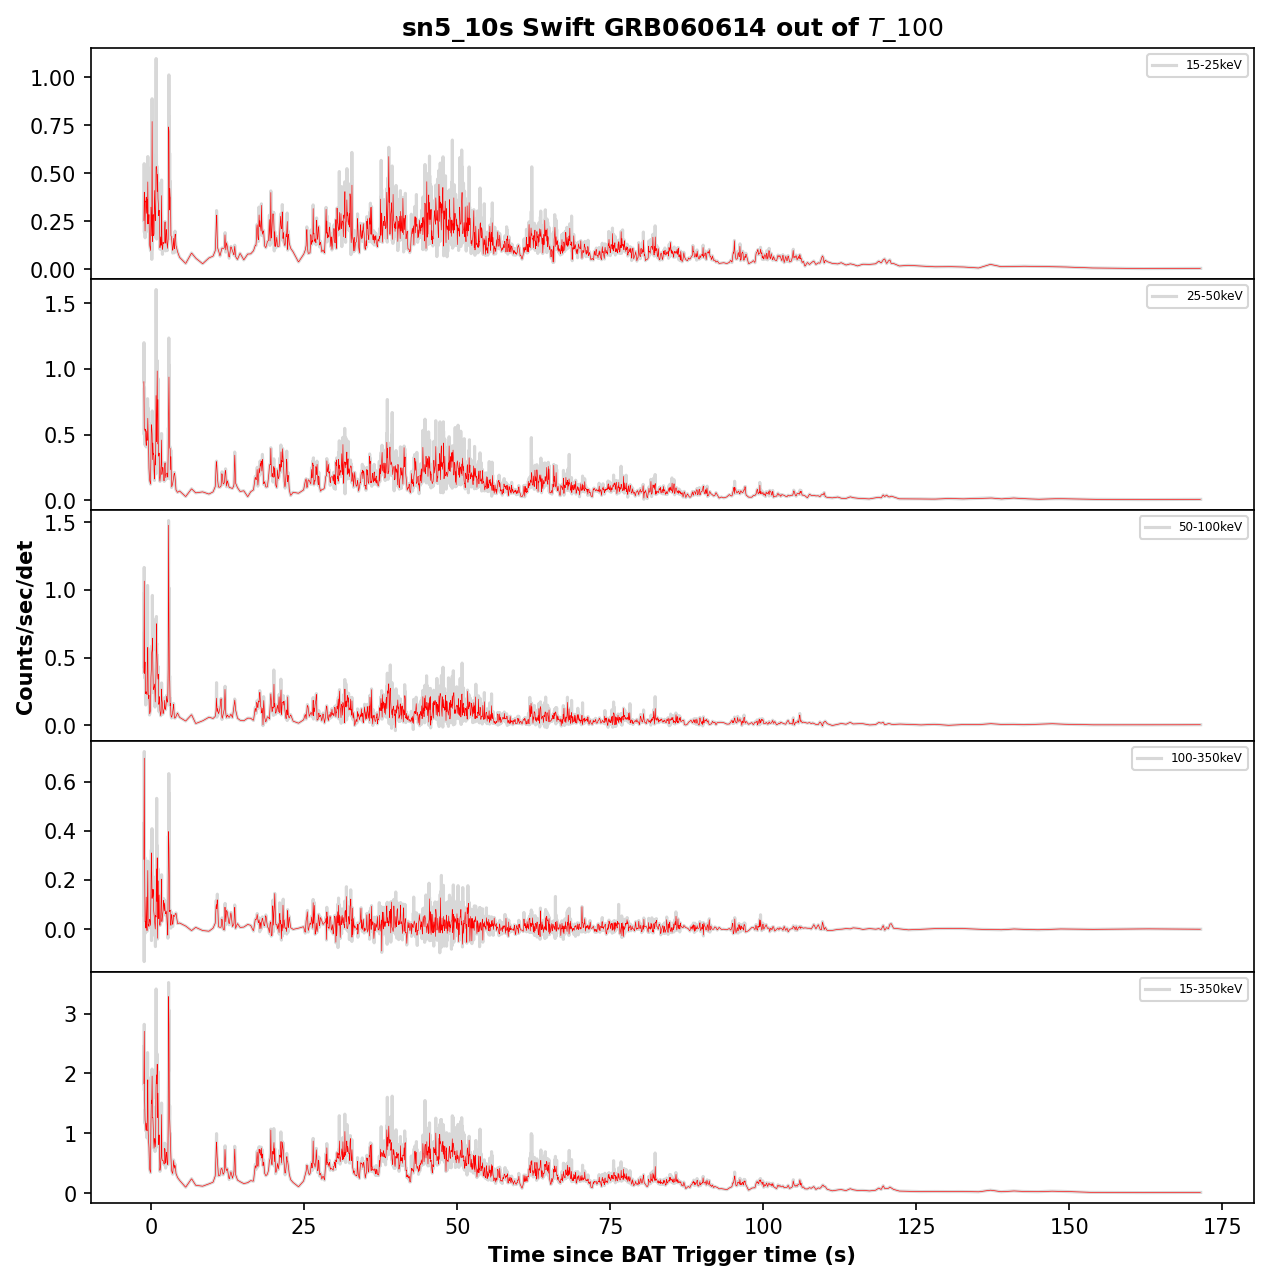

In [11]:
ax2 = swift.plot_any_grb(name, t=100, kind='Interpolated', figsize=(10, 10))
for i in range(0, len(inter_data.columns)-1, 1):
    ax2[i].plot(inter_data.iloc[:, 0], inter_data.iloc[:, i+1], c='r', linewidth=0.3)

As you can see, the interpolation results are still containing the main features than the original data. To further increase the matching results between the interpolated data and the original data, you can use a lower resolution interval (in example, 1 millisecond). But, this will increase the execution time. Another option depending on your needs is to set a custom time interval, using the `new_time` argument.

## Non-Linear Interpolation

The last section introduces the interpolation instance using only kind='linear'. Take the interpolation carefully when you use 2nd or 3rd order polynomial because it can return negative count values. Remember that the value of pack_num plays a significant role when you use high order polynomial. Lower pack_num improves the result but takes higher execution time.

Consider using a cubic interpolation for the example GRB using a pack of 100 data points and a fixed resolution of 32 milliseconds:

In [12]:
inter_data = swift.grb_interpolate(data=example, kind='cubic', res=32, pack_num=100)
print(inter_data)

        Time(s)  15-25keV  25-50keV  50-100keV  100-350keV  15-350keV
0      -1.16585  0.254273  0.902692   0.389372    0.284036   1.830370
1      -1.13385  0.521195  0.626879   0.561757    0.434345   2.144179
2      -1.10185  0.400681  0.533867   1.065990    0.785109   2.785647
3      -1.06985  0.275596  0.857748   0.975196    0.053964   2.162506
4      -1.03785  0.389316  0.491217   0.249770    0.278444   1.408743
...         ...       ...       ...        ...         ...        ...
5389  171.28215  0.005362  0.006208   0.003369   -0.000245   0.014695
5390  171.31415  0.005355  0.006204   0.003370   -0.000286   0.014644
5391  171.34615  0.005347  0.006200   0.003371   -0.000326   0.014593
5392  171.37815  0.005340  0.006196   0.003372   -0.000368   0.014541
5393  171.41015  0.005332  0.006191   0.003373   -0.000409   0.014488

[5394 rows x 6 columns]


Plot the results:

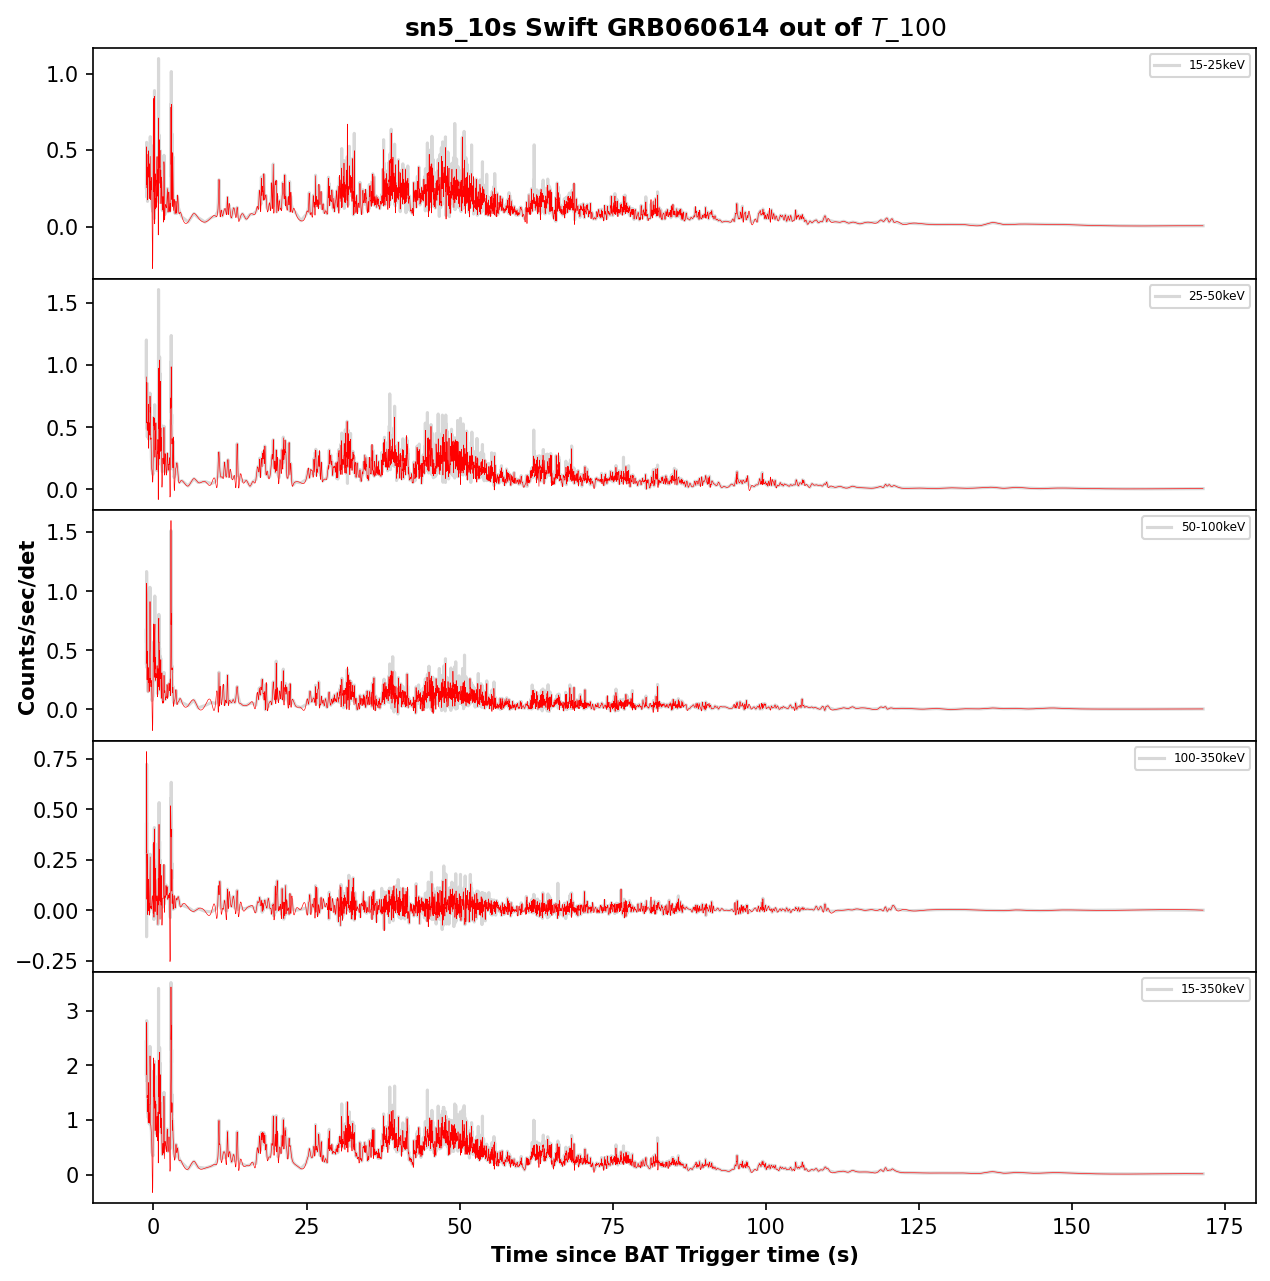

In [13]:
ax3 = swift.plot_any_grb(name, t=100, kind='Interpolated', figsize=(10, 10))
for i in range(0, len(inter_data.columns)-1, 1):
    ax3[i].plot(inter_data.iloc[:, 0], inter_data.iloc[:, i+1], c='r', linewidth=0.3)

The interpolation results are acceptable, but there are some negative values. To avoid this, you can use a lower order polynomial or a lower pack_num. Let's try with a quadratic interpolation and a pack of 5 data points:

**Note: Remember that for a cubic interpolation it is necessary to have at least 4 data points. So, the pack_num must be at least 4. The same idea can be applied to quadratic and other type of interpolation.**

In [14]:
inter_data = swift.grb_interpolate(data=example, kind='quadratic', res=32, pack_num=5)
print(inter_data)

        Time(s)  15-25keV  25-50keV  50-100keV  100-350keV  15-350keV
0      -1.16585  0.254273  0.902692   0.389372    0.284036   1.830370
1      -1.13385  0.521200  0.626875   0.561850    0.433759   2.143686
2      -1.10185  0.386126  0.529929   0.987784    0.708202   2.612040
3      -1.06985  0.276998  0.857212   0.978571    0.056044   2.168827
4      -1.03785  0.437447  0.422645   0.221910    0.275768   1.357765
...         ...       ...       ...        ...         ...        ...
5389  171.28215  0.005276  0.006123   0.003362   -0.000372   0.014389
5390  171.31415  0.005286  0.006136   0.003365   -0.000388   0.014399
5391  171.34615  0.005296  0.006149   0.003367   -0.000403   0.014409
5392  171.37815  0.005306  0.006162   0.003369   -0.000418   0.014419
5393  171.41015  0.005316  0.006175   0.003372   -0.000434   0.014429

[5394 rows x 6 columns]


Plot the results:

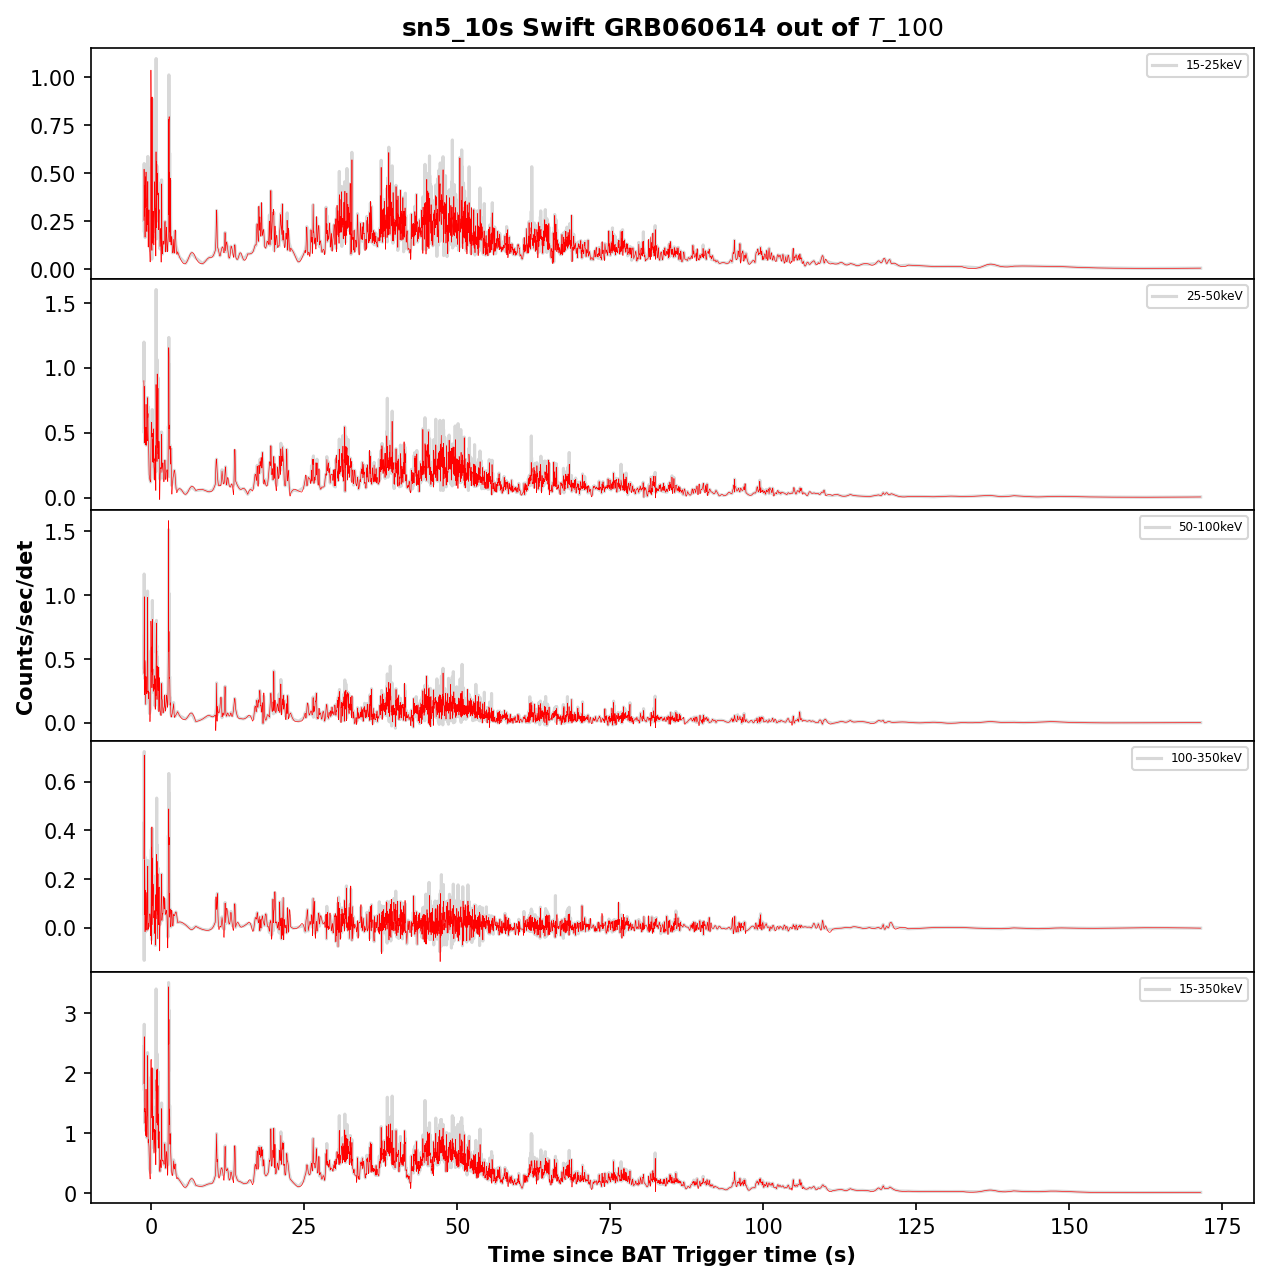

In [15]:
ax4 = swift.plot_any_grb(name, t=100, kind='Interpolated', figsize=(10, 10))
for i in range(0, len(inter_data.columns)-1, 1):
    ax4[i].plot(inter_data.iloc[:, 0], inter_data.iloc[:, i+1], c='r', linewidth=0.3)

The result interpolation improves a lot compared with the last case! The pack_num value depends on how you want to sacrifice time execution with interpolation accuracy (Remember, only for high order polynomial).

At this point, we want to highlight that the results depend on the data itself, but the time execution goes can increase exponentially. So, you must be careful when you use a non-linear interpolation. The best option is to use a linear interpolation with a low resolution interval, at least in our current usage of **ClassiPyGRB**.

**WARNING: When interp1d instance of scipy fails, it sets by default kind = 'linear'. This is specially important in redundant cases, for example $pack\_num = 2$ when $kind = 'cubic'$ (cubic interpolation isn't possible with 2 points).**

In [16]:
del inter_data, example, ax, ax2, ax3, ax4  # Delete unused variables

## Pre-processing interpolated data

The next step is to interpolate all GRBs and pre-process them using the same rules as in Data_Preprocessing notebook. However, we can go directly to limit all light curves and interpolate them using the so_much_interpolate instance with t=100:

**WARNING: The zero-pad process can use a lot of memory. So, it is recommended to test with a higher resolution interval for computers with less than 16GB of RAM.**

In [4]:
limited_data, GRB_names, errors = swift.parallel_lc_limiter(GRB_names)
print(f'There are {len(limited_data)} GRBs limited and {len(errors)} errors.')
print(errors)

LC limiting: 100%|██████████| 1498/1498 [00:01<00:00, 1225.44GRB/s]


There are 1326 GRBs limited and 172 errors.
         Names t_start  t_end       Error
0   GRB041219B                 ValueError
0    GRB050202   0.004  0.132    Length=0
0    GRB050406  -2.504  3.896    Length=2
0    GRB050421   0.044   8.74    Length=1
0   GRB050509B     0.0  0.028    Length=0
..         ...     ...    ...         ...
0   GRB211207A  -1.304  2.972    Length=2
0   GRB220302A  -1.864  5.384    Length=2
0   GRB220319A  -0.364  6.564    Length=2
0   GRB220404A    0.16  5.984    Length=2
0   GRB220708A  -1.296  2.704    Length=2

[172 rows x 4 columns]


Interpolate data linearly with a fixed resolution of (for example) 30 milliseconds:

In [5]:
resolution = 15
interpolated_data = swift.parallel_grb_interpolate(limited_data, kind='linear', res=resolution)
del limited_data

Interpolating: 100%|██████████| 1326/1326 [00:00<00:00, 1586.26GRB/s]


Normalizing data:

In [6]:
normalized_data = swift.parallel_lc_normalize(interpolated_data)  # Normalizing all light curves
del interpolated_data  # Delete unused variable

LC Normalizing: 100%|██████████| 1326/1326 [00:00<00:00, 1383.37GRB/s]


Zero-padding:

In [7]:
zero_padded_data = swift.parallel_zero_pad(normalized_data)
del normalized_data  # Delete unused variable

LC Zero-Padding: 100%|██████████| 1326/1326 [00:06<00:00, 217.05GRB/s]


Concatenating data:

In [8]:
concatenated_data = swift.parallel_concatenate(zero_padded_data)  # Concatenate data without DFT

Concatenating: 100%|██████████| 1326/1326 [00:07<00:00, 173.11GRB/s]


Performing DFT:

In [9]:
pre_processing_data = swift.parallel_dft_spectrum(concatenated_data)

Performing DFT: 100%|██████████| 1326/1326 [00:10<00:00, 128.65GRB/s]


Finally, save the results:

In [10]:
swift.save_results(f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True_Interpolated_at_{resolution}ms.npz', names=GRB_names, data=pre_processing_data)  # Save Data with DFT

In [11]:
swift.save_results(f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_False_Interpolated_at_{resolution}ms.npz', names=GRB_names, data=concatenated_data)  # Save Data without DFT